In [1]:
%matplotlib inline
import sys
sys.path.append('/home/paulo/git/bayeseg')

import time
import datetime

import numpy as np
import pandas as pd

from SeqSeg.SeqSeg import SeqSeg

savefolder = '/home/paulo/git/bayeseg/Output/'

## Testing the algorithm on real samples

In [2]:
from OceanPod import OceanPod 


wavfolder = '/home/paulo/github/bayeseg/Data/'
savefolder = '/home/paulo/github/bayeseg/Output/'
filelist = ['2015.01.30_02.02.56.wav', '2015.02.02_07.50.49.wav', '2015.02.08_11.26.39.wav']

# Creates object to read wave files and segments
op = OceanPod(wavfolder)

In [3]:
# MCMC parameters

mciter = 20000
mcburn = 20000
nchains = 1


In [63]:
ss = SeqSeg(replicate = False)

file = filelist[2]

fs, wave = op.readFile(file)
ss.feed_data(wave)

alpha = 0.1
beta = 5e-5
ss.initialize(beta, alpha, mciter, mcburn, nchains)

%time tseg, tdur = ss.segments(minlen = 1, res = 11025, verbose = False)
nseg = len(tseg) + 1
print(nseg)



CPU times: user 964 ms, sys: 28 ms, total: 992 ms
Wall time: 989 ms
32


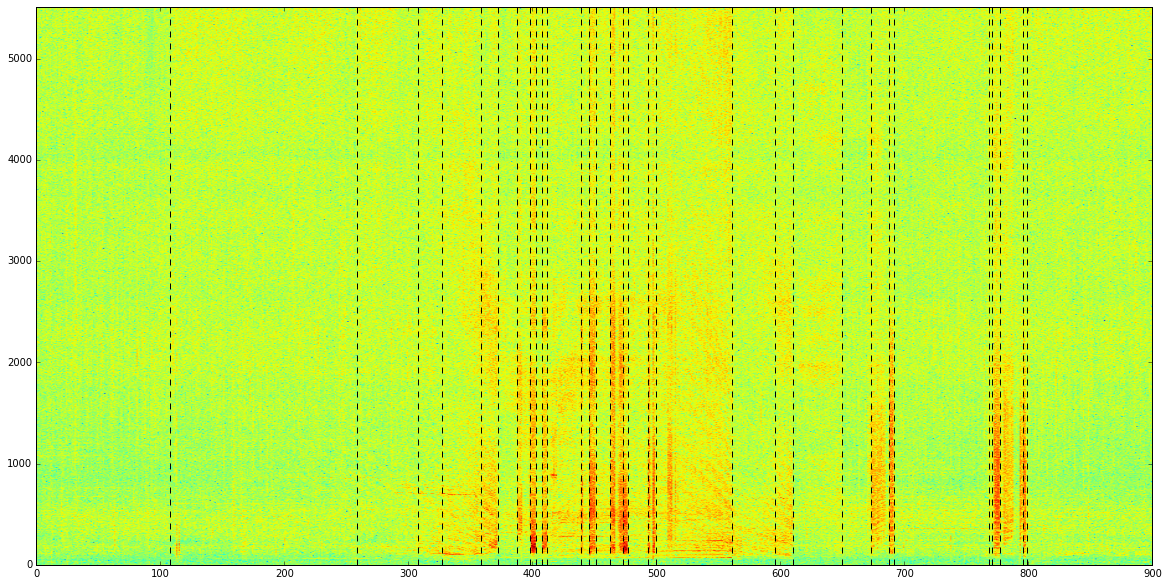

In [64]:
from matplotlib import pyplot as plt
from matplotlib import colors

M = 11025
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
spec, freq, t, f = ax.specgram(wave, NFFT=M, Fs=fs, Fc=0, noverlap = 0,
         cmap=plt.cm.jet, xextent=None, pad_to=None, sides='default',
         scale_by_freq=None, mode='psd', scale='default', detrend = 'default', window = np.blackman(M))
ax.set_ylim([0, np.max(freq)])
for s in tseg:
    ax.axvline(x = s/fs, linestyle = '--', color = 'black')

In [67]:
ss = SeqSeg(replicate = False)

file = filelist[2]

fs, wave = op.readFile(file)
ss.feed_data(wave)

alpha = 0.1
beta = 5e-5
ss.initialize(beta, alpha, mciter, mcburn, nchains)

%time tseg, tdur = ss.segments(minlen = 1, res = 1, verbose = False)
nseg = len(tseg) + 1
print(nseg)



CPU times: user 22.3 s, sys: 8 ms, total: 22.3 s
Wall time: 22.3 s
38


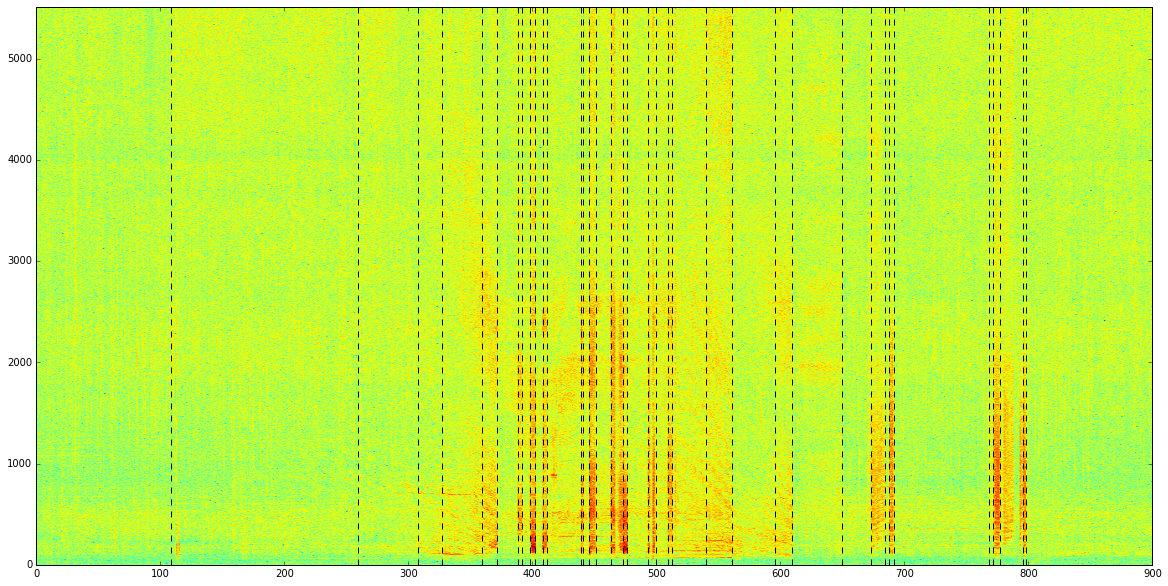

In [68]:
from matplotlib import pyplot as plt
from matplotlib import colors

M = 11025
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
spec, freq, t, f = ax.specgram(wave, NFFT=M, Fs=fs, Fc=0, noverlap = 0,
         cmap=plt.cm.jet, xextent=None, pad_to=None, sides='default',
         scale_by_freq=None, mode='psd', scale='default', detrend = 'default', window = np.blackman(M))
ax.set_ylim([0, np.max(freq)])
for s in tseg:
    ax.axvline(x = s/fs, linestyle = '--', color = 'black')